# 3. Model Training

In this notebook, I train and compare three different models to find the best one for predicting flat prices.

## 3.1 Load Preprocessed Data

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load processed data
X_train = joblib.load('../data/processed/X_train.pkl')
X_val = joblib.load('../data/processed/X_val.pkl')
y_train = joblib.load('../data/processed/y_train.pkl')
y_val = joblib.load('../data/processed/y_val.pkl')
X_train_scaled = joblib.load('../data/processed/X_train_scaled.pkl')
X_val_scaled = joblib.load('../data/processed/X_val_scaled.pkl')
feature_cols = joblib.load('../data/processed/feature_cols.pkl')

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Number of features: {len(feature_cols)}")

Training samples: 80,000
Validation samples: 20,000
Number of features: 17


## 3.2 Evaluation Function

I use RMSE, MAE, and R-squared to evaluate model performance.

In [2]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display evaluation metrics."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f"{model_name} - Validation Results")
    print(f"{'='*50}")
    print(f"  RMSE:  {rmse:>15,.0f} rubles")
    print(f"  MAE:   {mae:>15,.0f} rubles")
    print(f"  R2:    {r2:>15.4f}")
    
    return {'model': model_name, 'rmse': rmse, 'mae': mae, 'r2': r2}

## 3.3 Linear Regression (Baseline)

Starting with a simple linear model as a baseline to compare against.

In [3]:
from sklearn.linear_model import LinearRegression

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on validation set
lr_pred = lr_model.predict(X_val)

# Evaluate
lr_results = evaluate_model(y_val, lr_pred, "Linear Regression")

# Save model
joblib.dump(lr_model, '../models/linear_regression.pkl')
print("\nModel saved to: ../models/linear_regression.pkl")


Linear Regression - Validation Results
  RMSE:        2,542,843 rubles
  MAE:         2,269,072 rubles
  R2:             0.8022

Model saved to: ../models/linear_regression.pkl


In [4]:
# Show feature coefficients
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False)

print("\nFeature Coefficients (Linear Regression):")
print(coef_df.to_string(index=False))


Feature Coefficients (Linear Regression):
             Feature   Coefficient
     central_heating  1.203792e+06
          bath_count  4.456904e+05
          total_area  1.857690e+05
         ceil_height  1.455047e+05
           hot_water  1.443952e+05
                 gas  1.211064e+05
    extra_area_count  1.038030e+05
        kitchen_area  9.511491e+04
           bath_area  4.617259e+04
          other_area  3.964264e+04
               floor  2.795686e+04
          extra_area  1.451666e+04
                year -1.764669e+03
extra_area_type_name -4.842972e+03
           floor_max -3.106242e+04
       district_name -4.098436e+04
         rooms_count -1.722615e+05


## 3.4 XGBoost

XGBoost is a gradient boosting algorithm that builds an ensemble of decision trees.

In [5]:
import xgboost as xgb

# Train model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,     # Number of boosting rounds
    max_depth=6,          # Tree depth limit
    learning_rate=0.1,    # Step size
    random_state=42       # Reproducibility
)

xgb_model.fit(X_train, y_train)

# Predict on validation set
xgb_pred = xgb_model.predict(X_val)

# Evaluate
xgb_results = evaluate_model(y_val, xgb_pred, "XGBoost")

# Save model
joblib.dump(xgb_model, '../models/xgboost_model.pkl')
print("\nModel saved to: ../models/xgboost_model.pkl")


XGBoost - Validation Results
  RMSE:          230,083 rubles
  MAE:           178,699 rubles
  R2:             0.9984

Model saved to: ../models/xgboost_model.pkl


### Overfitting Check

Comparing training vs validation performance to check if the model overfits.

Evaluating XGBoost on training set...

TRAINING SET PERFORMANCE
  RMSE:          216,539 rubles
  MAE:           170,189 rubles
  R²:           0.998584

VALIDATION SET PERFORMANCE
  RMSE:          230,083 rubles
  MAE:           178,699 rubles
  R²:           0.998381

PERFORMANCE GAP (Training - Validation)
  RMSE Gap:          -13,544 rubles
  MAE Gap:            -8,510 rubles
  R² Gap:           0.000203


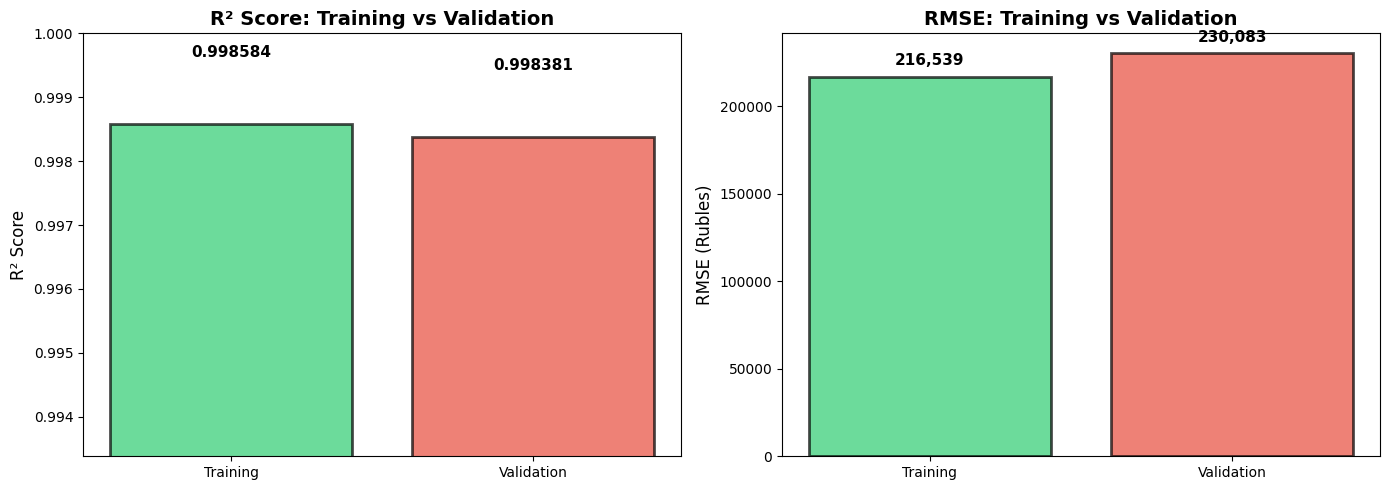

In [6]:
# Evaluate on TRAINING set
print("Evaluating XGBoost on training set...")
train_pred = xgb_model.predict(X_train)

# Calculate training metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

# Calculate validation metrics (already done, but let's recalculate for comparison)
val_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
val_mae = mean_absolute_error(y_val, xgb_pred)
val_r2 = r2_score(y_val, xgb_pred)

# Display comparison
print("\n" + "="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)
print(f"  RMSE:  {train_rmse:>15,.0f} rubles")
print(f"  MAE:   {train_mae:>15,.0f} rubles")
print(f"  R²:    {train_r2:>15.6f}")

print("\n" + "="*60)
print("VALIDATION SET PERFORMANCE")
print("="*60)
print(f"  RMSE:  {val_rmse:>15,.0f} rubles")
print(f"  MAE:   {val_mae:>15,.0f} rubles")
print(f"  R²:    {val_r2:>15.6f}")

# Calculate gap
r2_gap = train_r2 - val_r2
rmse_gap = train_rmse - val_rmse
mae_gap = train_mae - val_mae

print("\n" + "="*60)
print("PERFORMANCE GAP (Training - Validation)")
print("="*60)
print(f"  RMSE Gap:  {rmse_gap:>15,.0f} rubles")
print(f"  MAE Gap:   {mae_gap:>15,.0f} rubles")
print(f"  R² Gap:    {r2_gap:>15.6f}")


# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
axes[0].bar(['Training', 'Validation'], [train_r2, val_r2], 
            color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score: Training vs Validation', fontsize=14, fontweight='bold')
axes[0].set_ylim([min(train_r2, val_r2) - 0.005, 1.0])
for i, (label, val) in enumerate(zip(['Training', 'Validation'], [train_r2, val_r2])):
    axes[0].text(i, val + 0.001, f'{val:.6f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# RMSE comparison
axes[1].bar(['Training', 'Validation'], [train_rmse, val_rmse],
            color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('RMSE (Rubles)', fontsize=12)
axes[1].set_title('RMSE: Training vs Validation', fontsize=14, fontweight='bold')
for i, (label, val) in enumerate(zip(['Training', 'Validation'], [train_rmse, val_rmse])):
    axes[1].text(i, val + 5000, f'{val:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "="*60)

### Feature Importance

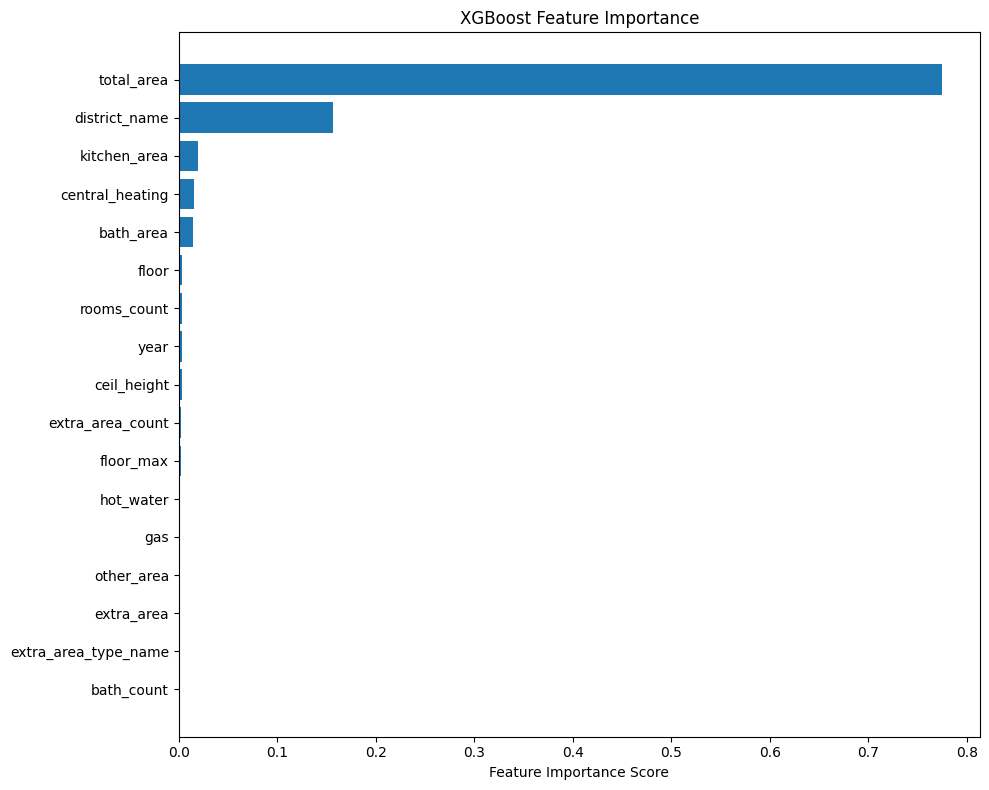


Top 5 Most Important Features:
  total_area          : 0.7745
  district_name       : 0.1562
  kitchen_area        : 0.0192
  central_heating     : 0.0155
  bath_area           : 0.0146


In [7]:
# Get feature importance
importance = xgb_model.feature_importances_
sorted_idx = np.argsort(importance)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Print top 5 features
print("\nTop 5 Most Important Features:")
for i in sorted_idx[-5:][::-1]:
    print(f"  {feature_cols[i]:20s}: {importance[i]:.4f}")

## 3.5 Neural Network

A feedforward neural network with two hidden layers (64 and 32 neurons) using ReLU activation and dropout for regularization.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
tf.random.set_seed(42)

# Build model
nn_model = Sequential([
    # Hidden Layer 1: 64 neurons with ReLU activation
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),  # 20% dropout for regularization
    
    # Hidden Layer 2: 32 neurons with ReLU activation
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    # Output Layer: 1 neuron with linear activation (regression)
    Dense(1, activation='linear')
])

# Compile model
nn_model.compile(
    optimizer='adam',      # Adaptive learning rate optimizer
    loss='mse',            # Mean Squared Error for regression
    metrics=['mae']        # Track Mean Absolute Error
)

# Show model summary
nn_model.summary()

c:\Users\LOQ\Desktop\CI Module\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

### Training with Early Stopping

Early stopping monitors validation loss and stops training when it stops improving.

In [9]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train model (using scaled data for neural network)
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,            # Maximum epochs (early stopping will likely trigger first)
    batch_size=32,         # Process 32 samples at a time
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 285752395038720.0000 - mae: 15908794.0000 - val_loss: 280174725693440.0000 - val_mae: 15784513.0000
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 264193588592640.0000 - mae: 15356730.0000 - val_loss: 243965769023488.0000 - val_mae: 14832819.0000
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 214646275440640.0000 - mae: 13960325.0000 - val_loss: 182637780008960.0000 - val_mae: 12969277.0000
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 148483277324288.0000 - mae: 11638423.0000 - val_loss: 114738356813824.0000 - val_mae: 10199670.0000
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 90391227400192.0000 - mae: 8779943.0000 - val_loss: 67564084396032.0000 - val_mae: 7388068.0000
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 58300188065792.0000 - mae: 6645097.5000 - val_loss: 44663180361728.0000 - val_mae: 5656895.0000
Epoch 7/100
2500/2500 ━━━━━━━━

### Training History

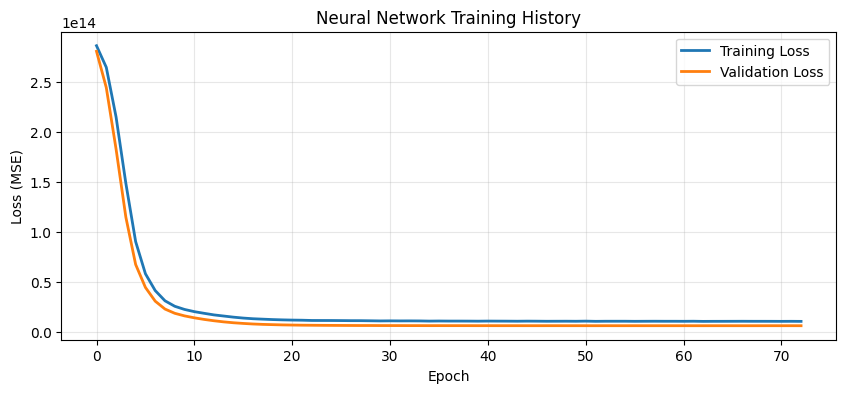

Training stopped at epoch 73


In [10]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Neural Network Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training stopped at epoch {len(history.history['loss'])}")

In [11]:
# Evaluate neural network
nn_pred = nn_model.predict(X_val_scaled, verbose=0).flatten()
nn_results = evaluate_model(y_val, nn_pred, "Neural Network")

# Save model
nn_model.save('../models/neural_network.keras')
print("\nModel saved to: ../models/neural_network.keras")


Neural Network - Validation Results
  RMSE:        2,546,964 rubles
  MAE:         2,239,205 rubles
  R2:             0.8016

Model saved to: ../models/neural_network.keras


## 3.6 Model Comparison

In [12]:
# Create comparison table
results_df = pd.DataFrame([lr_results, xgb_results, nn_results])
results_df['rmse'] = results_df['rmse'].apply(lambda x: f"{x:,.0f}")
results_df['mae'] = results_df['mae'].apply(lambda x: f"{x:,.0f}")
results_df['r2'] = results_df['r2'].apply(lambda x: f"{x:.4f}")

print("\n" + "="*60)
print("MODEL COMPARISON TABLE")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


MODEL COMPARISON TABLE
            model      rmse       mae     r2
Linear Regression 2,542,843 2,269,072 0.8022
          XGBoost   230,083   178,699 0.9984
   Neural Network 2,546,964 2,239,205 0.8016


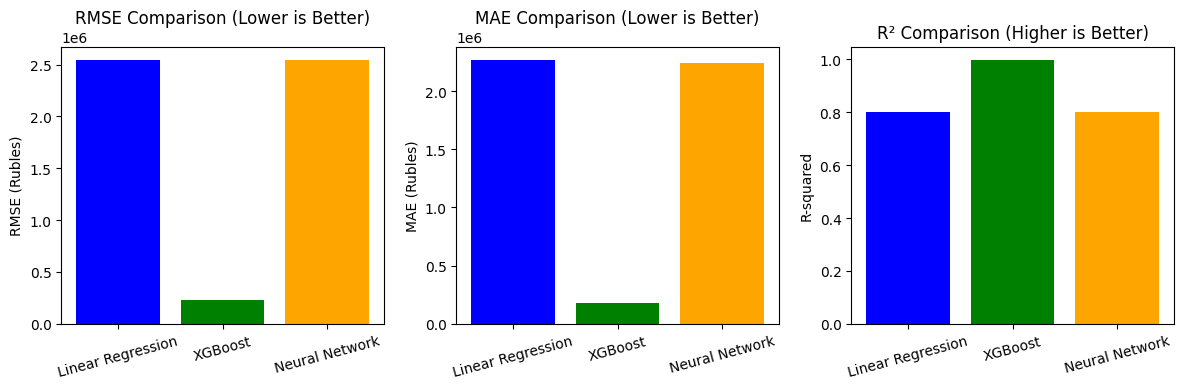

In [13]:
# Visual comparison
results_numeric = pd.DataFrame([lr_results, xgb_results, nn_results])

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# RMSE comparison
axes[0].bar(results_numeric['model'], results_numeric['rmse'], color=['blue', 'green', 'orange'])
axes[0].set_ylabel('RMSE (Rubles)')
axes[0].set_title('RMSE Comparison (Lower is Better)')
axes[0].tick_params(axis='x', rotation=15)

# MAE comparison
axes[1].bar(results_numeric['model'], results_numeric['mae'], color=['blue', 'green', 'orange'])
axes[1].set_ylabel('MAE (Rubles)')
axes[1].set_title('MAE Comparison (Lower is Better)')
axes[1].tick_params(axis='x', rotation=15)

# R2 comparison
axes[2].bar(results_numeric['model'], results_numeric['r2'], color=['blue', 'green', 'orange'])
axes[2].set_ylabel('R-squared')
axes[2].set_title('R² Comparison (Higher is Better)')
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

In [14]:
# Save results for reference
import os
os.makedirs('../outputs', exist_ok=True)
results_df.to_csv('../outputs/model_comparison.csv', index=False)
print("Results saved to: ../outputs/model_comparison.csv")

Results saved to: ../outputs/model_comparison.csv


## 3.7 Conclusion

**Selected Model: XGBoost**

XGBoost achieved the best results with R² = 0.9984 and the lowest RMSE.

### Note on Neural Network Performance

I trained a Multi-Layer Perceptron (MLP) to see if deep learning could outperform the tree-based XGBoost. However, the results show that for this tabular dataset, the tree-based approach is superior. I kept the Neural Network implementation to demonstrate the architectural differences in training deep models versus ensemble methods.